In [1]:
import time
import matplotlib.pyplot as plt
import seaborn as sns
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, desc, when, count as spark_count, concat_ws, length, rand, row_number
from pyspark.sql.window import Window
import pandas as pd

from pyspark.ml.feature import StringIndexer, RegexTokenizer, StopWordsRemover, Word2Vec
from pyspark.ml.classification import LogisticRegression
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.sql.functions import col

def measure_time(func, *args, **kwargs):
    start = time.perf_counter()
    result = func(*args, **kwargs)
    end = time.perf_counter()
    return result, end - start

measure_time

<function __main__.measure_time(func, *args, **kwargs)>

In [2]:
spark = SparkSession.builder \
    .appName("RAID-VISUALIZE") \
    .master("spark://spark-master:7077") \
    .getOrCreate()

spark

In [3]:
df = spark.read.json("hdfs://namenode:8020/user/raid/raw")
df

DataFrame[attack: string, domain: string, features: array<double>, generation: string, id: string, model: string]

In [4]:
from pyspark.ml.functions import array_to_vector
df = df.withColumn("features", array_to_vector(col("features")))
df = df.repartition(128)
df

DataFrame[attack: string, domain: string, features: vector, generation: string, id: string, model: string]

In [5]:
from pyspark.ml.feature import PCA
pca = PCA(k=2, inputCol="features", outputCol="pca_features")
pca_model = pca.fit(df)
pca_result = pca_model.transform(df)

In [6]:
pca_result

DataFrame[attack: string, domain: string, features: vector, generation: string, id: string, model: string, pca_features: vector]

In [7]:
print("Mengonversi ke Pandas...")
pca_pd, _ = measure_time(lambda: pca_result.select("model", "pca_features").toPandas())

Mengonversi ke Pandas...


In [8]:
# Ekstrak komponen PCA
pca_pd["pca_x"] = pca_pd["pca_features"].apply(lambda v: float(v[0]))
pca_pd["pca_y"] = pca_pd["pca_features"].apply(lambda v: float(v[1]))

# Opsional: tampilkan explained variance
explained_var = pca_model.explainedVariance.toArray()
print(f"Explained Variance (PC1, PC2): {explained_var[0]:.3f}, {explained_var[1]:.3f}")

Explained Variance (PC1, PC2): 0.568, 0.154


In [9]:
pca_pd

,model,pca_features,pca_x,pca_y
0,human,"[-0.49887472245027475, -1.588459481606679]",-0.498875,-1.588459
1,gpt4,"[3.227592692210679, -0.5863374602126226]",3.227593,-0.586337
2,gpt4,"[-0.5674884712198466, -1.6220814097971017]",-0.567488,-1.622081
3,human,"[-0.5476504781987862, -1.5845555593725347]",-0.547650,-1.584556
4,gpt4,"[-0.5761415118180402, -1.7039470870775595]",-0.576142,-1.703947
...,...,...,...,...
481351,gpt4,"[3.4353915974688953, -0.6224881205536775]",3.435392,-0.622488
481352,gpt4,"[3.4313240929098496, -0.6011120830272338]",3.431324,-0.601112
481353,gpt4,"[3.3402390154502015, -0.5542141453332559]",3.340239,-0.554214
481354,gpt4,"[3.3277797219093186, -0.691868496028057]",3.327780,-0.691868


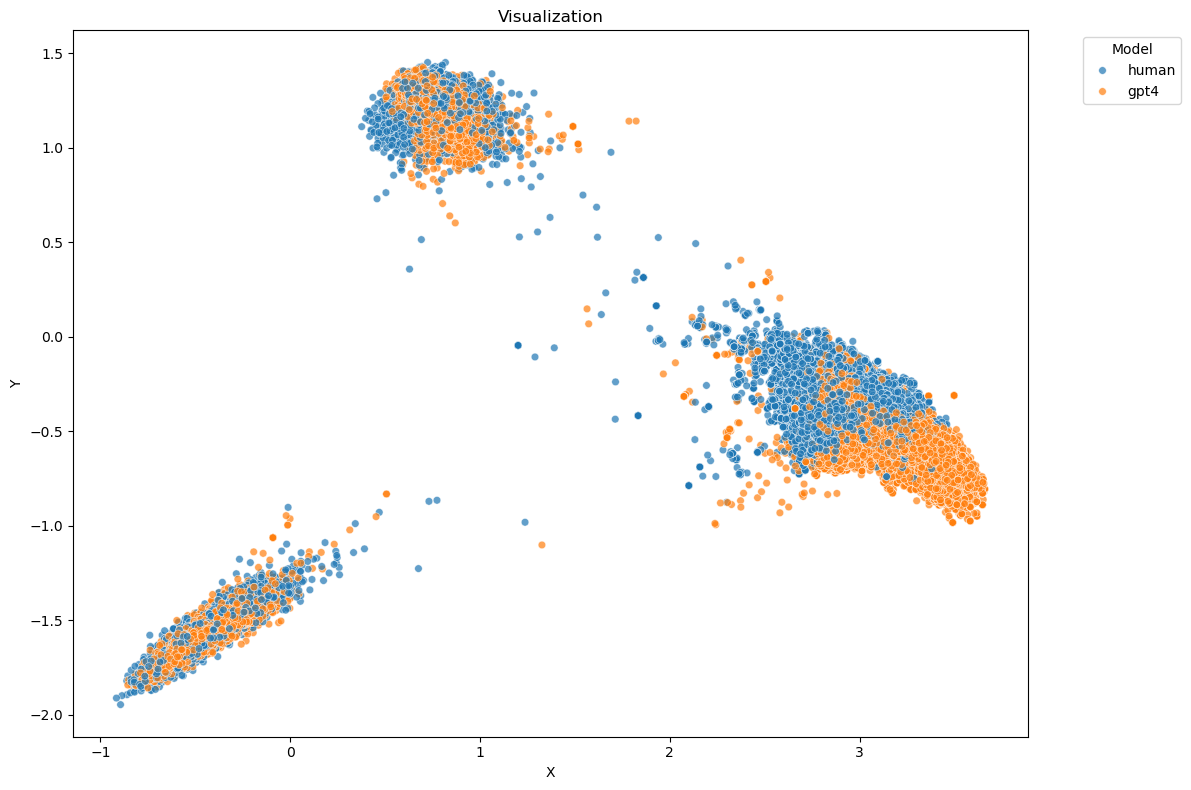

In [10]:
# 5. Visualisasi dengan Seaborn/Matplotlib
plt.figure(figsize=(12, 8))
sns.scatterplot(
    data=pca_pd,
    x="pca_x",
    y="pca_y",
    hue="model",
    palette="tab10",
    alpha=0.7,
    s=30
)
plt.title("Visualization")
plt.xlabel(f"X")
plt.ylabel(f"Y")
plt.legend(title="Model", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig("pca_minilm_2d.png", dpi=150)
plt.show()

In [11]:
print("Menghentikan SparkSession...")
spark.stop()
print("✅ SparkSession dihentikan.")

Menghentikan SparkSession...
✅ SparkSession dihentikan.
